### **Project work in Artificial Intelligence in Industry at University of Bologna - Master's degree in Artificial Intelligence**

#### Stefano Poggi Cavalletti

## **Anomaly Detection in ECG Signals**

The aim of this project is to perform anomaly detection in time series, in particular on health data related to ECG signals, which are recordings of the heart's electrical activity. To perform this task, we will use an available dataset which contains ECG data of real patients: ECG5000.
After analyzing the data we will use deep learning techniques which include autoencoders and their variation with LSTM, in order to perform signal reconstruction and be able to distinguish a normal signal from an anomaly, which happens when some kind of arrhythmia is present.

### Dataset

The [ECG5000](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000) dataset is available in the UCR Time Series Classification archive and contains a set of 5000 univariate time series with 140 timesteps. Each sequence corresponds to a single heartbeat extracted from a single patient. Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle. In general, the frequency is 60-100 beat per minute and the duration of each heartbeat is 0.6–1 second.

Five classes are annotated, corresponding to the following labels: 

*   Normal (N)
*   R-on-T Premature Ventricular Contraction (R-on-T 
PVC)
*   Premature Ventricular Contraction (PVC)
*   Supra-ventricular Premature or Ectopic Beat (SP or EB)
*   Unclassified Beat (UB)





In [104]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers,losses
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
# Import the dataset files

ecg_train_file = 'ECG5000_TRAIN.csv'
ecg_test_file = 'ECG5000_TEST.csv'

train_data = pd.read_csv(ecg_train_file)
test_data = pd.read_csv(ecg_test_file)

df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

We combine the training and test data into a single dataframe and we drop irrelevant columns.

In [3]:
df = pd.concat([df_train, df_test], ignore_index=True)

In [4]:
df = df.drop(labels='id', axis=1)

In [5]:
# 140 timesteps + target
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [6]:
df

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,...,t132,t133,t134,t135,t136,t137,t138,t139,t140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,4
4996,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,2
4997,-1.351779,-2.209006,-2.520225,-3.061475,-3.065141,-3.030739,-2.622720,-2.044092,-1.295874,-0.733839,...,-1.512234,-2.076075,-2.586042,-3.322799,-3.627311,-3.437038,-2.260023,-1.577823,-0.684531,2
4998,-1.124432,-1.905039,-2.192707,-2.904320,-2.900722,-2.761252,-2.569705,-2.043893,-1.490538,-0.938473,...,-2.821782,-3.268355,-3.634981,-3.168765,-2.245878,-1.262260,-0.443307,-0.559769,0.108568,2


There is a total of 5000 examples, where each row represents a single heartbeat record. There are five values from 1 to 5 in the 'target' column, representing the five possible classes available. We will now name the different classes to perform some data analysis.

In [7]:
normal_class = 1
class_names = ['Normal','R on T','PVC','SP','UB']

### Exploratory Data Analysis

In [8]:
df['target'].value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

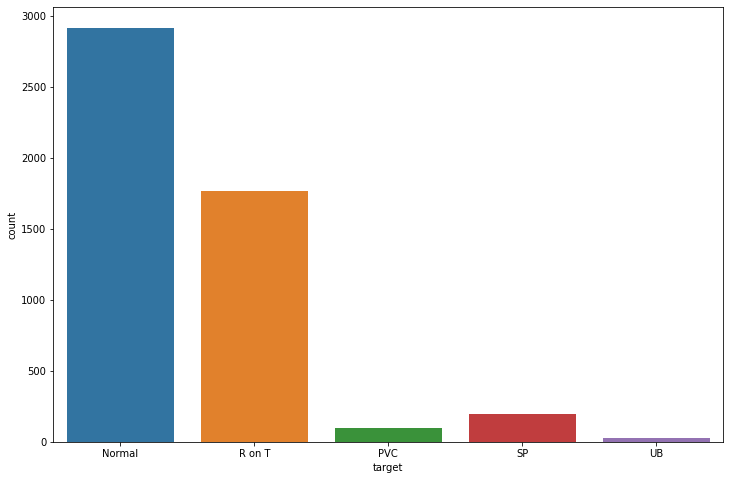

In [9]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x=df.target)
ax.set_xticklabels(class_names);

As we can see, classes are very unbalanced, with normal class being the most common with 2919 sequences, followed by the class with label R-on-T PVC. However, this might turn out useful to train our model. Moreover, if we sum all the remaining abnormal sequences we get a total value of 2081, which gets closer to the amount of normal sequences.

Now we plot an averaged time series for each class, smoothed out with a standard deviation around it:

In [38]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.200
  )
  ax.set_title(class_name)

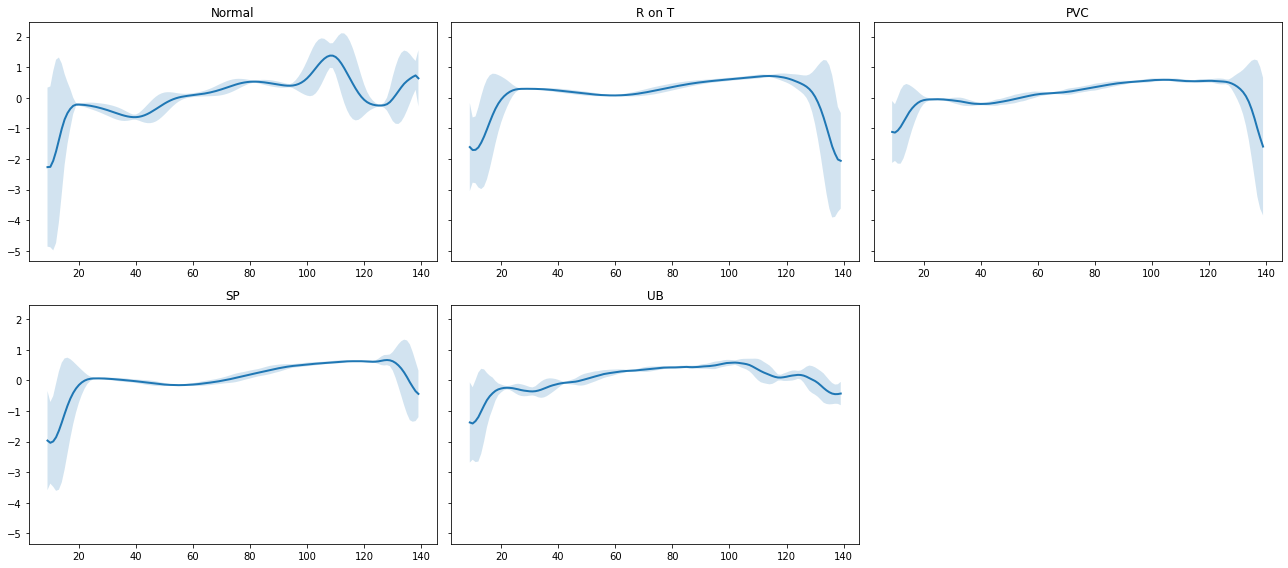

In [39]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(18, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()    
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

We can notice how the normal class has a distinctly different pattern compared to all the other abnormal classes. The blue line indicates the overall average amplitude, surrounded by one standard deviation in both sides, depicted in light blue.

### Data Preprocessing

We now split the data into training, validation and test sets with the following proportion: 67% for the training set and the remaining 33% equally split between validation and test sets.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df.values,
                                                    df.values[:,-1], 
                                                    test_size=0.33,
                                                    random_state=RANDOM_SEED)

X_test, X_val, y_test, y_val = train_test_split(X_test,
                                                    y_test, 
                                                    test_size=0.5,
                                                    random_state=RANDOM_SEED)

In [42]:
# Boolean y_test labels array which has True values if signal is normal, False otherwise
y_test_b = [label == 1 for label in y_test]

In [43]:
print('The shape of the training set: ', X_train.shape)
print('The shape of the validation set:  ', X_val.shape)
print('The shape of the test set:  ', X_test.shape)

The shape of the training set:  (3350, 141)
The shape of the validation set:   (825, 141)
The shape of the test set:   (825, 141)


As normalization pre-processing technique, we apply MinMax scaler to the input signals in order to scale and translate them into a [0, 1] range.

In [44]:
scaler = MinMaxScaler()
data_scaled = scaler.fit(X_train[:,:-1])    

In [45]:
X_train[:,:-1] = data_scaled.transform(X_train[:,:-1])
X_val[:,:-1] = data_scaled.transform(X_test[:,:-1])
X_test[:,:-1] = data_scaled.transform(X_test[:,:-1])

In [46]:
# Training data normalized
X_train

array([[0.46681314, 0.30598663, 0.12742944, ..., 0.78191394, 0.41294765,
        1.        ],
       [0.41180487, 0.31892916, 0.18172118, ..., 0.72852918, 0.43351424,
        1.        ],
       [0.513428  , 0.50326213, 0.46856169, ..., 0.55135431, 0.54012112,
        2.        ],
       ...,
       [0.40693666, 0.32245156, 0.20183108, ..., 0.78800865, 0.50709418,
        1.        ],
       [0.35152641, 0.36020066, 0.34101396, ..., 0.53237887, 0.47770011,
        2.        ],
       [0.31662141, 0.21167853, 0.14875345, ..., 0.69607321, 0.35023474,
        1.        ]])

We now prepare the data for training our model: we divide the signals into normal (if the class is equal to 1) and anomalous (if the class is > 1), each one with its training, validation and test sets.

In [48]:
df_train = pd.DataFrame(X_train)
df_val = pd.DataFrame(X_val)
df_test = pd.DataFrame(X_test)

In [49]:
def select_normal_signals(df):
  df = df[df.iloc[:,-1] == 1].drop(columns=df.columns[-1], axis=1)
  return df.values

def select_anomalous_signals(df):
  df = df[df.iloc[:,-1] > 1].drop(columns=df.columns[-1], axis=1)
  return df.values

In [52]:
normal_X_train = select_normal_signals(df_train)
normal_X_val = select_normal_signals(df_val) 
normal_X_test = select_normal_signals(df_test)

In [53]:
print('The shape of the normal signals training set: ', normal_X_train.shape)
print('The shape of the normal signals validation set:  ', normal_X_val.shape)
print('The shape of the normal signals test set:  ', normal_X_test.shape)

The shape of the normal signals training set:  (1932, 140)
The shape of the normal signals validation set:   (492, 140)
The shape of the normal signals test set:   (495, 140)


The same process is applied to the anomalous signals:

In [54]:
anomaly_X_train = select_anomalous_signals(df_train)
anomaly_X_val = select_anomalous_signals(df_val) 
anomaly_X_test = select_anomalous_signals(df_test)

In [55]:
print('The shape of the normal signals training set: ', anomaly_X_train.shape)
print('The shape of the normal signals validation set:  ', anomaly_X_val.shape)
print('The shape of the normal signals test set:  ', anomaly_X_test.shape)

The shape of the normal signals training set:  (1418, 140)
The shape of the normal signals validation set:   (333, 140)
The shape of the normal signals test set:   (330, 140)


We plot five normal signals and five anomalous signals to compare them and find out the main variations.

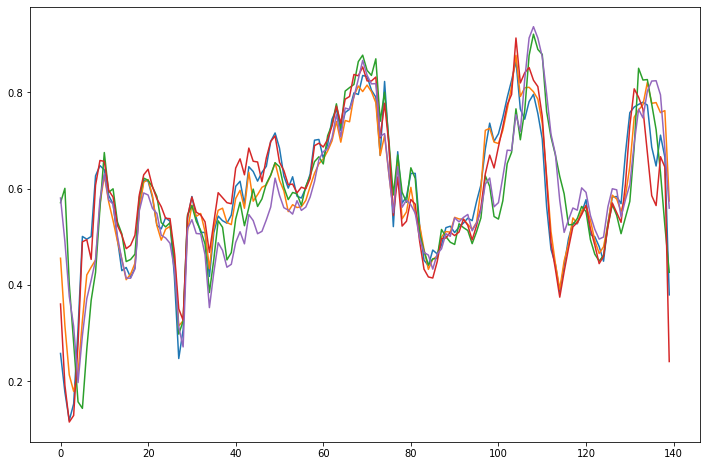

In [56]:
plt.figure(figsize=(12,8)) 

for i in range(5,10):
  plt.plot(normal_X_train[i])

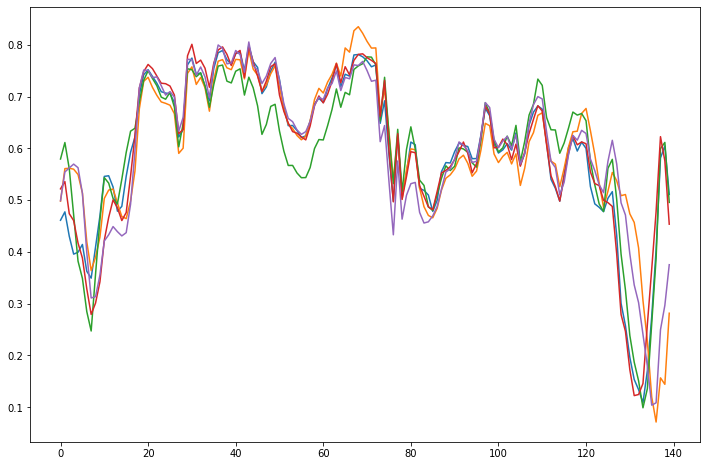

In [57]:
plt.figure(figsize=(12,8)) 

for i in range(5,10):
  plt.plot(anomaly_X_train[i])

These plots confirm the pattern seen before for the normal and anomalous signals.

## Autoencoder

The objective of an autoencoder is to obtain a reconstruction of the given input, minimizing its reconstruction error. The reconstruction should match the input as much as possible. Since autoencoders try to learn only the most important features, meaning the compressed version of the data, it is usually a good idea to use a small number of parameters.

We will train an autoencoder solely on the normal ECG sequences, such that it reconstructs these examples with minimal error. The idea is the following: abnormal rhythms should have a higher reconstruction error compared to the normal sequences, allowing us to classify a rhythm as an anomaly if the reconstruction error is higher than a given threshold.

As previously said, the objective is to reconstruct the input as best as possible and this is done by minimizing a loss function, known as reconstruction loss. In this case we will minimize the MSE (Mean Squared Error), which is defined as the mean of the squared difference between the network's output and the ground truth: 
MSE = $\frac{1}{n} \Sigma_{i=1}^n({y}-\hat{y})^2$.


In [60]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    # Define the encoder 
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    # Define the decoder 
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    # Define how an evaluation of the network is performed
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [61]:
autoencoder = AutoEncoder()

early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss', 
                    patience=5,
                    mode='min',
                    restore_best_weights=True)

lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=5, 
    min_lr=1e-6, 
    mode='min')

autoencoder.compile(optimizer='adam', loss='mse')

In [62]:
history = autoencoder.fit(normal_X_train, normal_X_train, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(normal_X_val, normal_X_val),
                    callbacks=[early_stopping, lr_plateau],
                    shuffle=True)

Epoch 1/100
16/16 [==============================] - 2s 25ms/step - loss: 0.0248 - val_loss: 0.0208 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0131 - val_loss: 0.0146 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 0.0134 - lr: 0.0010
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0131 - lr: 0.0010
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0053 - val_loss: 0.0129 - lr: 0.0010
Epoch 6/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0124 - lr: 0.0010
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0124 - lr: 0.0010
Epoch 8/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0121 - lr: 0.0010
Epoch 9/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0050 - val_loss: 0.0114 - lr

In [65]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                144       
                                                                 
 dense_5 (Dense)             (None, 32)                544       
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dense_7 (Dense)             (None, 140)               9100      
                                                                 
Total params: 11,900
Trainable params: 11,900
Non-trainable params: 0
_________________________________________________________________


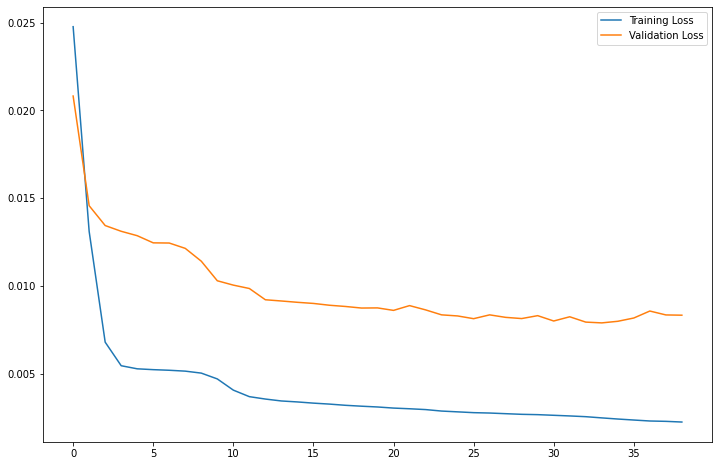

In [66]:
plt.figure(figsize=(12,8)) 
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

The autoencoder is made of dense layers and is trying to learn the distribution of the signal, in order to reproduce it as output. Since we are training it on the normal data it will learn to reproduce the normal data.

We now pass the normal test data into the model to obtain its decoded signal and plot its distribution, comparing it with its original shape. The process is done also for the anomalous data.

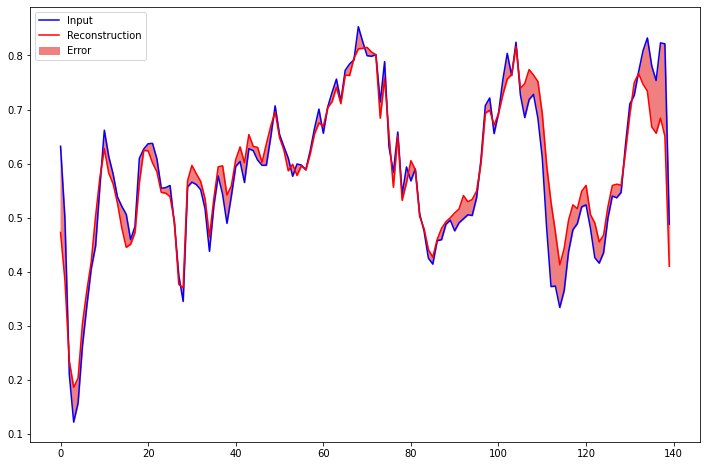

In [67]:
encoded_signal = autoencoder.encoder(normal_X_test).numpy()
decoded_signal = autoencoder.decoder(encoded_signal).numpy()

plt.figure(figsize=(12,8)) 
plt.plot(normal_X_test[0], 'b')
plt.plot(decoded_signal[0], 'r')
plt.fill_between(np.arange(140), decoded_signal[0], normal_X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

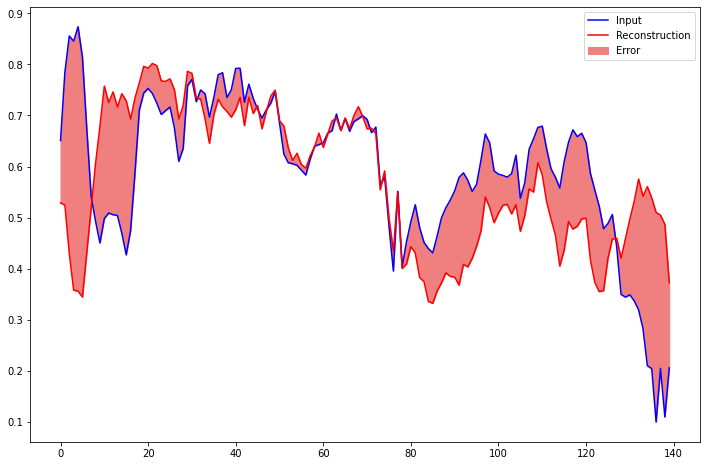

In [68]:
encoded_signal = autoencoder.encoder(anomaly_X_test).numpy()
decoded_signal = autoencoder.decoder(encoded_signal).numpy()

plt.figure(figsize=(12,8)) 
plt.plot(anomaly_X_test[0], 'b')
plt.plot(decoded_signal[0], 'r')
plt.fill_between(np.arange(140), decoded_signal[0], anomaly_X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

As we can see, the normal signals are fit more accurately, since the autoencoder is able to reconstruct them with lower error, while the reconstructed abnormal signals produce a higher error.

### Choosing a threshold

We now compute the mean squared error (MSE) of the normal and abnormal data, plotting their distribution and based on that we will choose the threshold.

In [69]:
reconstruction = autoencoder.predict(normal_X_train)
train_loss = tf.keras.losses.mse(reconstruction, normal_X_train) 

61/61 [==============================] - 0s 1ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of normal train data')]

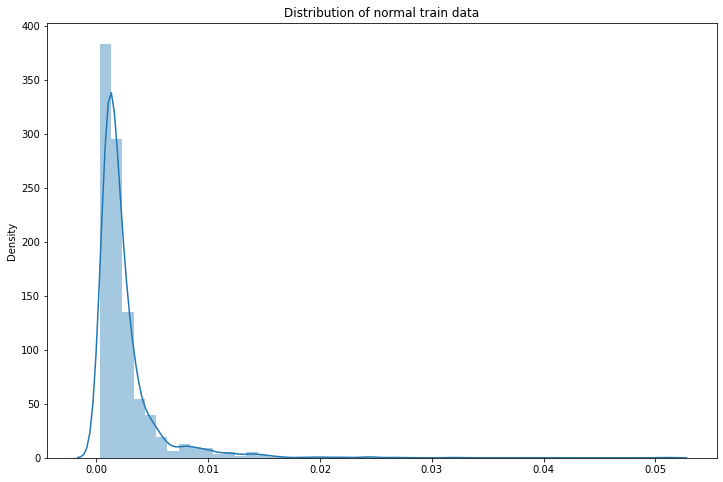

In [70]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(train_loss, bins=50, kde=True, ax=ax).set(title='Distribution of normal train data')

In [71]:
mean_normal = np.mean(train_loss)
std_normal = np.std(train_loss)

We compute the threshold value that is given by two standard deviations above the mean.

In [72]:
threshold = mean_normal + 2*std_normal
print("Threshold: ", threshold)

Threshold:  0.008441487925354579


### Evaluation

Using the computed threshold we can turn the problem into a binary classification task:
- if the reconstruction loss for an example is below the threshold, it will be classified as a normal heartbeat
- alteratively, if the loss is higher than the threshold, it will be classified as an anomaly

Evaluation on normal data

We now calculate the loss on the normal test data, plot the histogram and compute the correct number of predictions given the threshold.

In [73]:
reconstruction_test = autoencoder.predict(normal_X_test)
test_loss_normal = tf.keras.losses.mse(reconstruction_test, normal_X_test) 

16/16 [==============================] - 0s 2ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of normal test data')]

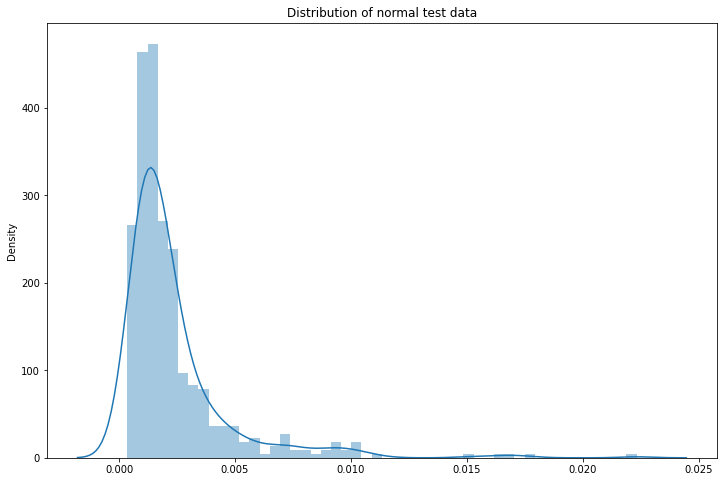

In [74]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(test_loss_normal, bins=50, kde=True, ax=ax).set(title='Distribution of normal test data')

In [75]:
correct_normal = [l <= threshold for l in test_loss_normal.numpy()]
print(f'Correct normal predictions: {np.count_nonzero(correct_normal)}/{len(normal_X_test)}')

Correct normal predictions: 477/495


Evaluation on anomalous data

In [76]:
reconstruction_anomalies = autoencoder.predict(anomaly_X_test)
test_loss_anomalies = tf.keras.losses.mse(reconstruction_anomalies, anomaly_X_test)

11/11 [==============================] - 0s 2ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of anomalous test data')]

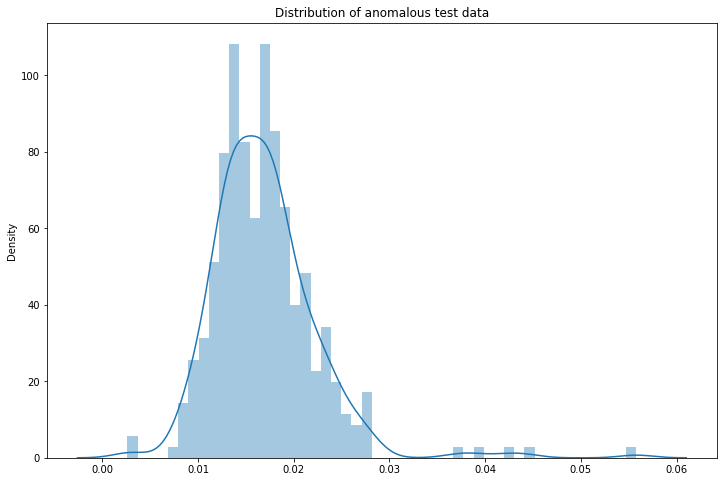

In [77]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(test_loss_anomalies, bins=50, kde=True, ax=ax).set(title='Distribution of anomalous test data')

In [78]:
correct = [l > threshold for l in test_loss_anomalies.numpy()]
print(f'Correct anomaly predictions: {np.count_nonzero(correct)}/{len(anomaly_X_test)}')

Correct anomaly predictions: 324/330


As we can see, it seems that the threshold allows to distinguish well the anomalies from normal signals: by varing the threshold, we can adjust the precision and recall of the classifier. We now put everything together:

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


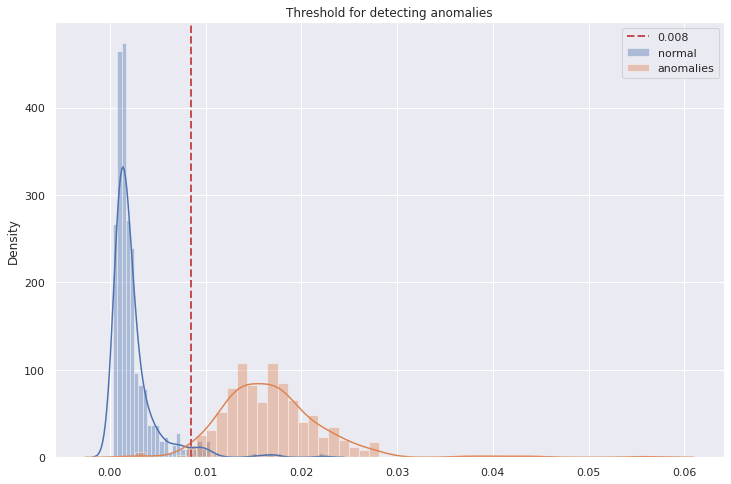

In [79]:
sns.set(rc={'figure.figsize':(12,8)})

# Plot two histograms of normal and abnormal data
sns.distplot(test_loss_normal.numpy(), bins=50, label='normal')
sns.distplot(test_loss_anomalies.numpy(), bins=50, label='anomalies')

# Plot a vertical line representing the threshold
plt.axvline(threshold, color='r', linewidth=2, linestyle='dashed', label='{:0.3f}'.format(threshold))

# Add legend and title
plt.legend(loc='upper right')
plt.title('Threshold for detecting anomalies')
plt.show()

### Confusion matrix and ROC curve

In order to plot the confusion matrix and ROC curve we first need to count the amount of false positives or false negatives: we compare the threshold with the test losses of normal and abnormal data and get an array of boolean values.

In [80]:
# We correctly detect normal data if the normal loss is smaller than the threshold
pred_normal = tf.math.less(test_loss_normal, threshold)

# We correctly detect abnormal data if the normal loss is greater than the threshold
pred_anomaly = tf.math.greater(test_loss_anomalies, threshold)

In [81]:
pred_normal_true = tf.math.count_nonzero(pred_normal).numpy()
pred_normal_false = normal_X_test.shape[0] - pred_normal_true
pred_normal_true, pred_normal_false

(477, 18)

In [82]:
pred_anomaly_true = tf.math.count_nonzero(pred_anomaly).numpy()
pred_anomaly_false = anomaly_X_test.shape[0] - pred_anomaly_true
pred_anomaly_true, pred_anomaly_false

(324, 6)

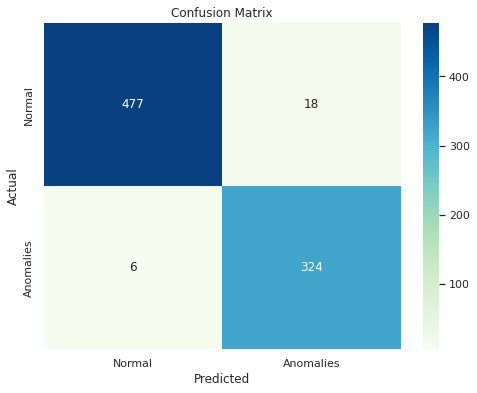

In [95]:
cm = [[pred_normal_true, pred_normal_false], 
      [pred_anomaly_false, pred_anomaly_true]]

categories = ['Normal', 'Anomalies']

plt.figure(figsize=(8,6))
g = sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=categories, 
            yticklabels=categories, 
            cmap="GnBu")

g.set(xlabel='Predicted', ylabel='Actual', title='Confusion Matrix')

plt.show()

Now we will predict True Positives (TP), False Negatives (FN), True Negatives (TN) and False Positives (FP).

In [97]:
def predict_metrics(normal, abnormal, threshold):
    # We correctly detect normal data if the normal loss is smaller than the threshold
    pred_normal = tf.math.less(normal, threshold)

    # We correctly detect abnormal data if the normal loss is greater than the threshold
    pred_anomaly = tf.math.greater(abnormal, threshold)

    tn = tf.math.count_nonzero(pred_normal).numpy()
    fp = normal.shape[0] - tn

    tp = tf.math.count_nonzero(pred_anomaly).numpy()
    fn = abnormal.shape[0] - tp
    
    return tp,tn,fp,fn

In [98]:
tpr_val = []
fpr_val = []

for t in np.linspace(0, 1, 100):
    tp, tn, fp, fn = predict_metrics(test_loss_normal, 
                                    test_loss_anomalies, 
                                    t/20)
    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)
    tpr_val.append(tpr)
    fpr_val.append(fpr)

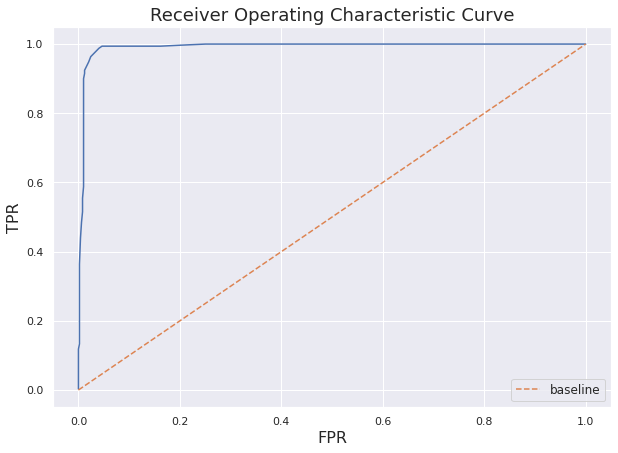

In [99]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_val, tpr_val)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);

Finally, we report the main results obtained by the model in terms of Accuracy, Precision, Recall, F1-Score and ROC-AUC score.

In [102]:
# Given model, test data and threshold, it computes the reconstruction data and the MSE reconstruction loss
# and returns the truth values of the loss which are less than the threshold.
# Then we compare the predictions with the true labels to obtain the metrics results

def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mse(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(np.round(accuracy_score(labels, preds),3)))
  print("Precision = {}".format(np.round(precision_score(labels, preds),3)))
  print("Recall = {}".format(np.round(recall_score(labels, preds),3)))
  print("F1-score = {}".format(np.round(f1_score(labels, preds),3)))
  print("ROC-AUC score = {}".format(np.round(roc_auc_score(labels, preds),3)))

In [101]:
preds = predict(autoencoder, X_test[:,:-1], threshold)
print_stats(preds, y_test_b)

Accuracy = 0.971
Precision = 0.988
Recall = 0.964
F1-score = 0.975
ROC-AUC score = 0.973


## LSTM Autoencoder

We now define a variation of the original autoencoder, which uses LSTM layers  to capture the temporal dependencies of the data. As before, we separate the encoder from the decoder: the Encoder uses two LSTM layers to compress the time series data input, while the decoder contains two LSTM layers and an output layer that gives the final reconstruction.

In [106]:
class LSTMAutoencoder(Model):
  def __init__(self):
    super(LSTMAutoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Reshape((normal_X_train.shape[1], 1)),
        layers.LSTM(128, input_shape=(normal_X_train.shape[1], 1), return_sequences=True),
        layers.LSTM(64, return_sequences=False),
    ])

    self.decoder = tf.keras.Sequential([
        layers.RepeatVector(normal_X_train.shape[1]),
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(128, return_sequences=True),
        layers.TimeDistributed(layers.Dense(1)),
        layers.Reshape((normal_X_train.shape[1],))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [107]:
LSTMautoencoder = LSTMAutoencoder()

In [108]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss', 
                    patience=5,
                    mode='min',
                    verbose=1,
                    restore_best_weights=True)

lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    verbose=1,
    mode='min')


In [109]:
LSTMautoencoder.compile(optimizer='adam', loss='mse')

history =  LSTMautoencoder.fit(normal_X_train, normal_X_train, 
                               epochs=50, 
                               validation_data=(normal_X_val, normal_X_val),
                               callbacks=[early_stopping, lr_plateau], 
                               shuffle=True)

Epoch 1/50
61/61 [==============================] - 61s 861ms/step - loss: 0.0376 - val_loss: 0.0253 - lr: 0.0010
Epoch 2/50
61/61 [==============================] - 36s 598ms/step - loss: 0.0181 - val_loss: 0.0237 - lr: 0.0010
Epoch 3/50
61/61 [==============================] - 41s 678ms/step - loss: 0.0177 - val_loss: 0.0218 - lr: 0.0010
Epoch 4/50
61/61 [==============================] - 32s 523ms/step - loss: 0.0174 - val_loss: 0.0202 - lr: 0.0010
Epoch 5/50
61/61 [==============================] - 32s 518ms/step - loss: 0.0169 - val_loss: 0.0190 - lr: 0.0010
Epoch 6/50
61/61 [==============================] - 34s 552ms/step - loss: 0.0156 - val_loss: 0.0169 - lr: 0.0010
Epoch 7/50
61/61 [==============================] - 32s 521ms/step - loss: 0.0143 - val_loss: 0.0170 - lr: 0.0010
Epoch 8/50
61/61 [==============================] - 33s 542ms/step - loss: 0.0124 - val_loss: 0.0171 - lr: 0.0010
Epoch 9/50
61/61 [==============================] - 32s 518ms/step - loss: 0.0107 - val_

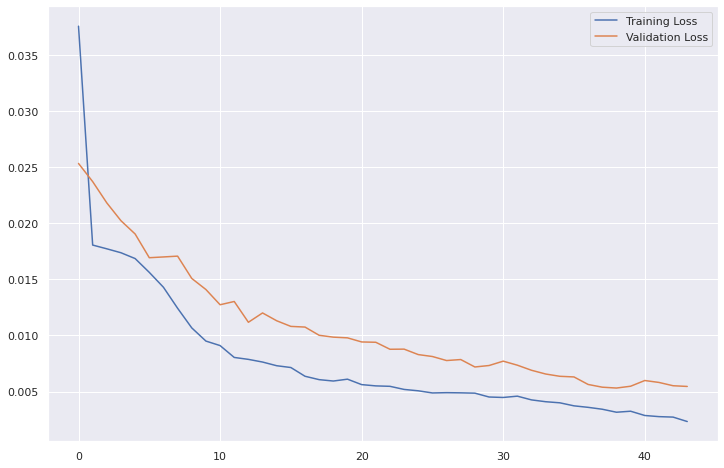

In [110]:
plt.figure(figsize=(12,8)) 
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

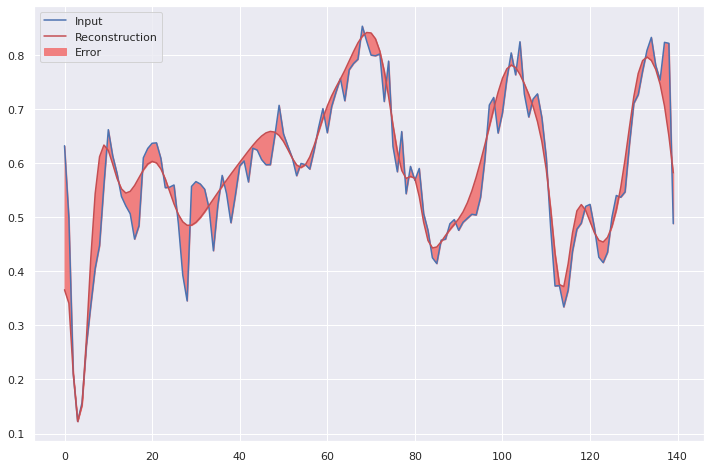

In [111]:
encoded_signal_lstm = LSTMautoencoder.encoder(normal_X_test).numpy()
decoded_signal_lstm = LSTMautoencoder.decoder(encoded_signal_lstm).numpy()

plt.figure(figsize=(12,8)) 
plt.plot(normal_X_test[0], 'b')
plt.plot(decoded_signal_lstm[0], 'r')
plt.fill_between(np.arange(140), decoded_signal_lstm[0], normal_X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

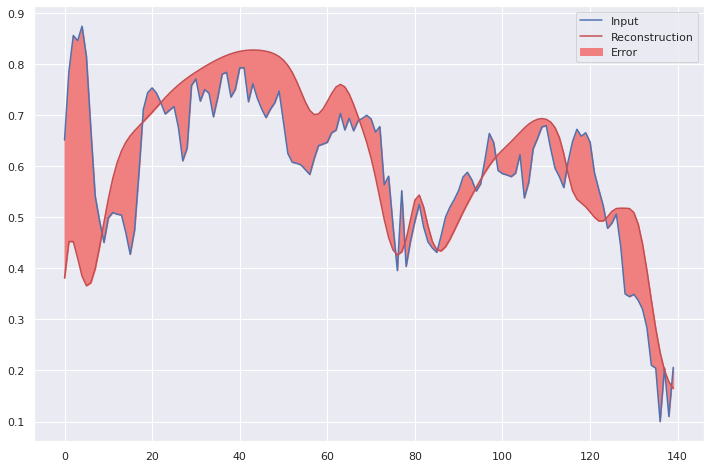

In [112]:
encoded_data_lstm = LSTMautoencoder.encoder(anomaly_X_test).numpy()
decoded_data_lstm = LSTMautoencoder.decoder(encoded_data_lstm).numpy()

plt.figure(figsize=(12,8)) 
plt.plot(anomaly_X_test[0], 'b')
plt.plot(decoded_data_lstm[0], 'r')
plt.fill_between(np.arange(140), decoded_data_lstm[0], anomaly_X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [113]:
reconstruction = LSTMautoencoder.predict(normal_X_train)
train_loss = tf.keras.losses.mse(reconstruction, normal_X_train) 

61/61 [==============================] - 11s 156ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of normal train data')]

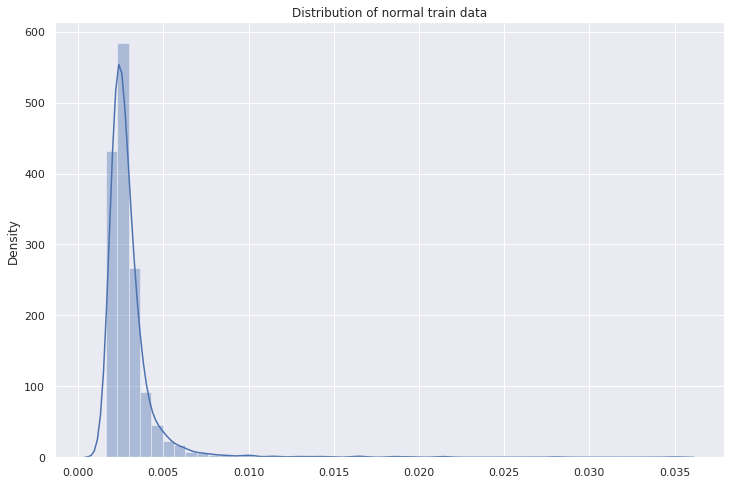

In [114]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(train_loss, bins=50, kde=True, ax=ax).set(title='Distribution of normal train data')

In [115]:
mean_normal = np.mean(train_loss)
std_normal = np.std(train_loss)

In [116]:
threshold = mean_normal + 2*std_normal
print("Threshold: ", threshold)

Threshold:  0.006694623058225485


### Evaluation

Evaluation on anomalous data

In [117]:
reconstruction_test = LSTMautoencoder.predict(normal_X_test)
test_loss_normal = tf.keras.losses.mse(reconstruction_test, normal_X_test) 

16/16 [==============================] - 2s 153ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of normal test data')]

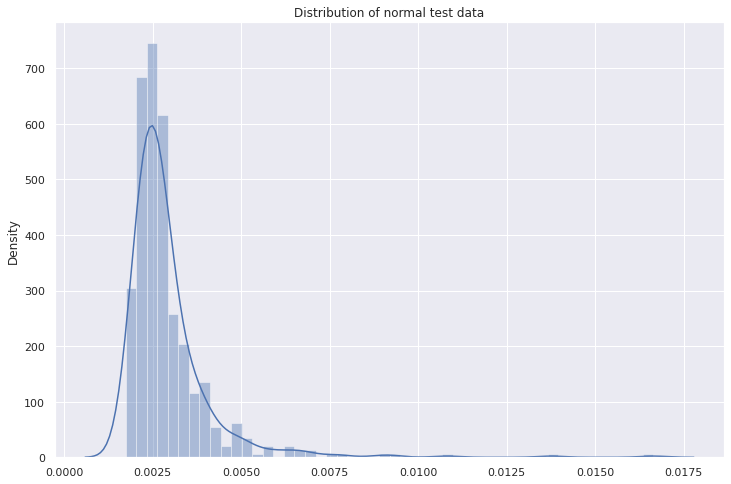

In [118]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(test_loss_normal, bins=50, kde=True, ax=ax).set(title='Distribution of normal test data')

In [119]:
correct_normal = [l <= threshold for l in test_loss_normal.numpy()]
print(f'Correct normal predictions: {np.count_nonzero(correct_normal)}/{len(normal_X_test)}')

Correct normal predictions: 486/495


Evaluation on anomalous data

In [120]:
reconstruction_anomalies = LSTMautoencoder.predict(anomaly_X_test)
test_loss_anomalies = tf.keras.losses.mse(reconstruction_anomalies, anomaly_X_test)

11/11 [==============================] - 2s 151ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of anomalous test data')]

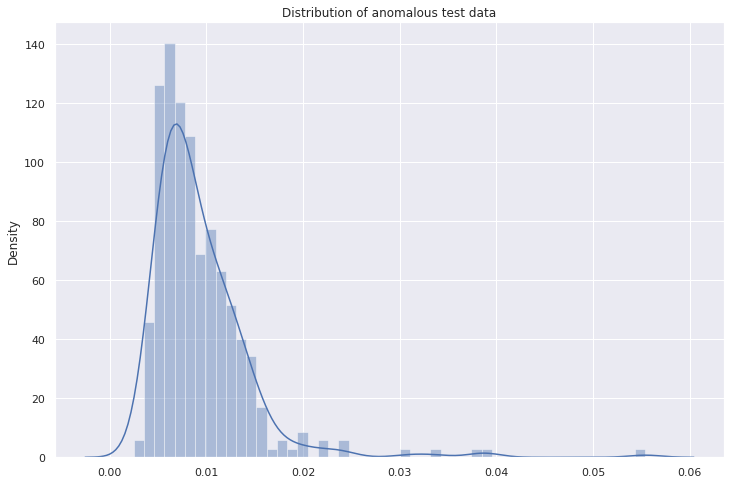

In [121]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(test_loss_anomalies, bins=50, kde=True, ax=ax).set(title='Distribution of anomalous test data')

In [122]:
correct = [l > threshold for l in test_loss_anomalies.numpy()]
print(f'Correct anomaly predictions: {np.count_nonzero(correct)}/{len(anomaly_X_test)}')

Correct anomaly predictions: 219/330


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


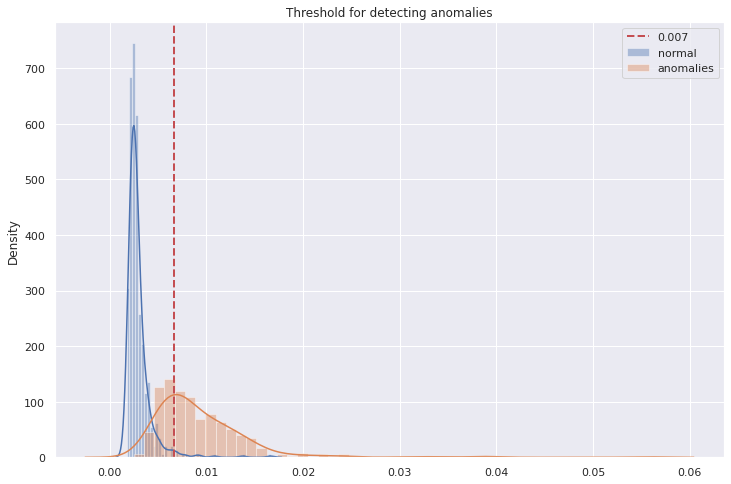

In [123]:
sns.set(rc={'figure.figsize':(12,8)})

# Plot two histograms of normal and abnormal data
sns.distplot(test_loss_normal.numpy(), bins=50, label='normal')
sns.distplot(test_loss_anomalies.numpy(), bins=50, label='anomalies')

# Plot a vertical line representing the threshold
plt.axvline(threshold, color='r', linewidth=2, linestyle='dashed', label='{:0.3f}'.format(threshold))

# Add legend and title
plt.legend(loc='upper right')
plt.title('Threshold for detecting anomalies')
plt.show()

### Confusion matrix

In [124]:
# We correctly detect normal data if the normal loss is smaller than the threshold
pred_normal = tf.math.less(test_loss_normal, threshold)

# We correctly detect abnormal data if the normal loss is greater than the threshold
pred_anomaly = tf.math.greater(test_loss_anomalies, threshold)

In [125]:
pred_normal_true = tf.math.count_nonzero(pred_normal).numpy()
pred_normal_false = normal_X_test.shape[0] - pred_normal_true
pred_normal_true, pred_normal_false

(486, 9)

In [126]:
pred_anomaly_true = tf.math.count_nonzero(pred_anomaly).numpy()
pred_anomaly_false = anomaly_X_test.shape[0] - pred_anomaly_true
pred_anomaly_true, pred_anomaly_false

(219, 111)

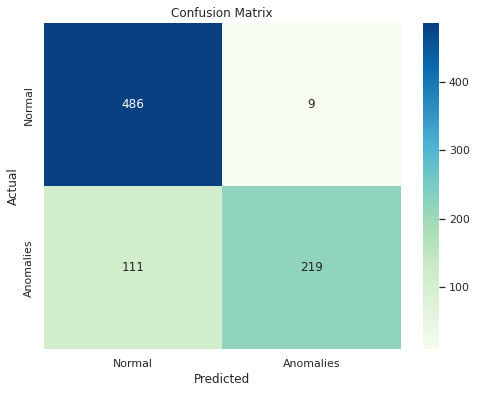

In [128]:
cm = [[pred_normal_true, pred_normal_false], 
      [pred_anomaly_false, pred_anomaly_true]]

categories = ['Normal', 'Anomalies']

plt.figure(figsize=(8,6))
g = sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=categories, 
            yticklabels=categories,
            cmap="GnBu")

g.set(xlabel='Predicted', ylabel='Actual', title='Confusion Matrix')

plt.show()

In [129]:
def predict_metrics(normal, abnormal, threshold):
    # We correctly detect normal data if the normal loss is smaller than the threshold
    pred_normal = tf.math.less(normal, threshold)
    
    # We correctly detect abnormal data if the normal loss is greater than the threshold
    pred_anomaly = tf.math.greater(abnormal, threshold)

    tn = tf.math.count_nonzero(pred_normal).numpy()
    fp = normal.shape[0] - tn

    tp = tf.math.count_nonzero(pred_anomaly).numpy()
    fn = abnormal.shape[0] - tp
    
    return tp,tn,fp,fn

In [130]:
tpr_val = []
fpr_val = []

for t in np.linspace(0, 1, 100):
    tp,tn,fp,fn = predict_metrics(test_loss_normal, 
                                  test_loss_anomalies, 
                                  t/20)
    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)
    tpr_val.append(tpr)
    fpr_val.append(fpr)

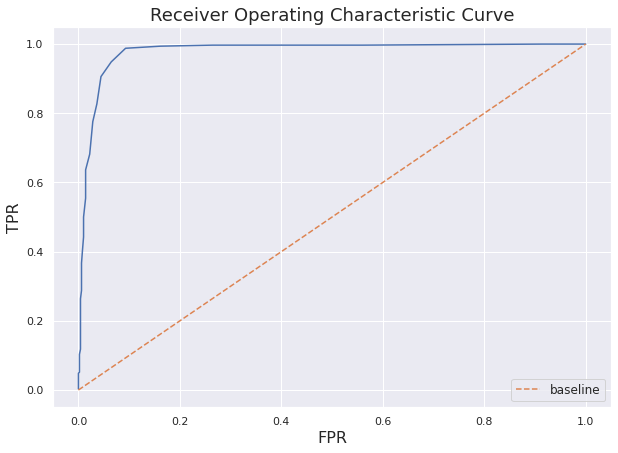

In [131]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_val, tpr_val)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);

In [132]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mse(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(np.round(accuracy_score(labels, preds),3)))
  print("Precision = {}".format(np.round(precision_score(labels, preds),3)))
  print("Recall = {}".format(np.round(recall_score(labels, preds),3)))
  print("F1-score = {}".format(np.round(f1_score(labels, preds),3)))
  print("ROC-AUC score = {}".format(np.round(roc_auc_score(labels, preds),3)))

Results obtained by the LSTM Autoencoder:

In [133]:
preds = predict(LSTMautoencoder, X_test[:,:-1], threshold)
print_stats(preds, y_test_b)

Accuracy = 0.855
Precision = 0.814
Recall = 0.982
F1-score = 0.89
ROC-AUC score = 0.823


### Final remarks

By comparing the results obtained by the traditional Autoencoder and the LSTM Autoencoder, we see how similar they performed to distinguish a normal ECG signal from an anomaly, with the first one obtaining slightly better results. Not only the model architecture itself is an important aspect to consider, but also the choice of the threshold, which indeed influences precision and recall of the model. Depending on the scenario and on what kind of errors we want to tolerate, it is possible to adjust the threshold. In this case, it might be a better idea to get more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).